In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset1000.xlsx")
df.head()

,label,komentar
0,positif,Oke pak boss!!
1,positif,PROBOWO is the WINNER of PEMILU 2014
2,positif,Hidup Pak Prabowo ..
3,positif,Ganteng bgt Pak :)
4,positif,ayo pak rujuk lagi sama bu titiek..hehhehe


In [3]:
df['label'].value_counts()

positif    1549
negatif     332
netral      120
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[oke, pak, boss]"
1,positif,"[probowo, is, the, winner, of, pemilu]"
2,positif,"[hidup, pak, prabowo]"
3,positif,"[ganteng, bgt, pak]"
4,positif,"[ayo, pak, rujuk, lagi, sama, bu, titiek, hehh..."
...,...,...
1996,negatif,"[jangan, lupa, n, jangan, dugal, y, buat, yg, ..."
1997,negatif,"[no, we]"
1998,negatif,"[pasang, foto, biar, laku, ya, joko, xixixixi]"
1999,negatif,"[gw, pilih, no, prabowo, hata]"


In [5]:
df_tambahan = pd.read_excel("dataset_tambahan.xlsx")
df_tambahan

,label,komentar
0,negatif,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,negatif,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,negatif,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
3,negatif,"Dari sekian banyak thread yang aku baca, threa..."
4,negatif,"Contoh mereka yg gemar menyudutkan, teriak pal..."
...,...,...
2093,netral,bukan saya yang tidak-mau merit sat ini hubung...
2094,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
2095,netral,Mengubah kebiasaan seseorang yg kurang baik it...
2096,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [6]:
komentar = df_tambahan['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df_tambahan['komentar'] = komentar
df_tambahan

,label,komentar
0,negatif,"[soal, jln, jatibaru, polisi, tdk, bs, gertak,..."
1,negatif,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,negatif,"[jln, jatibaru, bagian, dari, wilayah, tn, aba..."
3,negatif,"[dari, sekian, banyak, thread, yang, aku, baca..."
4,negatif,"[contoh, mereka, yg, gemar, menyudutkan, teria..."
...,...,...
2093,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
2094,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
2095,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
2096,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [7]:
df = df[df.komentar.astype(bool)]
df_tambahan = df_tambahan[df_tambahan.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train = X_train.append(df_tambahan.komentar)
y_train = y_train.append(df_tambahan.label)
y_train.value_counts()

negatif    1364
positif    1237
netral     1085
Name: label, dtype: int64

In [10]:
model = FastText.load('Model/XGB.bin')

In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [14]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [15]:
train=xgb.DMatrix(X_train_vector,label=y_train_enc)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.30168	test-merror:0.35427
[1]	train-merror:0.23142	test-merror:0.34673
[2]	train-merror:0.20347	test-merror:0.32161
[3]	train-merror:0.18692	test-merror:0.29146
[4]	train-merror:0.16603	test-merror:0.29397
[5]	train-merror:0.15003	test-merror:0.29648
[6]	train-merror:0.14514	test-merror:0.27387
[7]	train-merror:0.13592	test-merror:0.27638
[8]	train-merror:0.12995	test-merror:0.27387
[9]	train-merror:0.12344	test-merror:0.26884
[10]	train-merror:0.12208	test-merror:0.26884
[11]	train-merror:0.12046	test-merror:0.27136
[12]	train-merror:0.11503	test-merror:0.26884
[13]	train-merror:0.11422	test-merror:0.25879
[14]	train-merror:0.11069	test-merror:0.25628
[15]	train-merror:0.11150	test-merror:0.26131
[16]	train-merror:0.10743	test-merror:0.27387
[17]	train-merror:0.10526	test-merror:0.27638
[18]	train-merror:0.10933	test-merror:0.27387
[19]	train-merror:0.10309	test-merror:0.26633
[20]	train-merror:0.10282	test-merror:0.26633
[21]	train-merror:0.10065	test-merror:0.2713

[177]	train-merror:0.04992	test-merror:0.25126
[178]	train-merror:0.04965	test-merror:0.25126
[179]	train-merror:0.04938	test-merror:0.25628
[180]	train-merror:0.04938	test-merror:0.25628
[181]	train-merror:0.04965	test-merror:0.25628
[182]	train-merror:0.05019	test-merror:0.25377
[183]	train-merror:0.04992	test-merror:0.25377
[184]	train-merror:0.04992	test-merror:0.25377
[185]	train-merror:0.04911	test-merror:0.25377
[186]	train-merror:0.04829	test-merror:0.25628
[187]	train-merror:0.04856	test-merror:0.25377
[188]	train-merror:0.04829	test-merror:0.24874
[189]	train-merror:0.04856	test-merror:0.24874
[190]	train-merror:0.04775	test-merror:0.24623
[191]	train-merror:0.04802	test-merror:0.24874
[192]	train-merror:0.04693	test-merror:0.24623
[193]	train-merror:0.04721	test-merror:0.24874
[194]	train-merror:0.04693	test-merror:0.24623
[195]	train-merror:0.04693	test-merror:0.24623
[196]	train-merror:0.04666	test-merror:0.24874
[197]	train-merror:0.04639	test-merror:0.24874
[198]	train-m

[352]	train-merror:0.02957	test-merror:0.24623
[353]	train-merror:0.02984	test-merror:0.24623
[354]	train-merror:0.02957	test-merror:0.24372
[355]	train-merror:0.02930	test-merror:0.24623
[356]	train-merror:0.02903	test-merror:0.24623
[357]	train-merror:0.02930	test-merror:0.24372
[358]	train-merror:0.02903	test-merror:0.24623
[359]	train-merror:0.02876	test-merror:0.24623
[360]	train-merror:0.02876	test-merror:0.24623
[361]	train-merror:0.02794	test-merror:0.24623
[362]	train-merror:0.02794	test-merror:0.24623
[363]	train-merror:0.02849	test-merror:0.24623
[364]	train-merror:0.02822	test-merror:0.24623
[365]	train-merror:0.02794	test-merror:0.24372
[366]	train-merror:0.02822	test-merror:0.24372
[367]	train-merror:0.02849	test-merror:0.24372
[368]	train-merror:0.02849	test-merror:0.24372
[369]	train-merror:0.02794	test-merror:0.24372
[370]	train-merror:0.02794	test-merror:0.24372
[371]	train-merror:0.02794	test-merror:0.24372
[372]	train-merror:0.02794	test-merror:0.24121
[373]	train-m

[527]	train-merror:0.01763	test-merror:0.23869
[528]	train-merror:0.01736	test-merror:0.23869
[529]	train-merror:0.01736	test-merror:0.23869
[530]	train-merror:0.01736	test-merror:0.23869
[531]	train-merror:0.01736	test-merror:0.23869
[532]	train-merror:0.01736	test-merror:0.23618
[533]	train-merror:0.01709	test-merror:0.23618
[534]	train-merror:0.01709	test-merror:0.23618
[535]	train-merror:0.01682	test-merror:0.23618
[536]	train-merror:0.01682	test-merror:0.23618
[537]	train-merror:0.01709	test-merror:0.23618
[538]	train-merror:0.01682	test-merror:0.23618
[539]	train-merror:0.01682	test-merror:0.23618
[540]	train-merror:0.01682	test-merror:0.23618
[541]	train-merror:0.01682	test-merror:0.23618
[542]	train-merror:0.01655	test-merror:0.23618
[543]	train-merror:0.01628	test-merror:0.23618
[544]	train-merror:0.01628	test-merror:0.23618
[545]	train-merror:0.01628	test-merror:0.23618
[546]	train-merror:0.01628	test-merror:0.23869
[547]	train-merror:0.01628	test-merror:0.23618
[548]	train-m

[702]	train-merror:0.01004	test-merror:0.23618
[703]	train-merror:0.01004	test-merror:0.23618
[704]	train-merror:0.00977	test-merror:0.23618
[705]	train-merror:0.00949	test-merror:0.23618
[706]	train-merror:0.00949	test-merror:0.23618
[707]	train-merror:0.00949	test-merror:0.23869
[708]	train-merror:0.00922	test-merror:0.23618
[709]	train-merror:0.00949	test-merror:0.23618
[710]	train-merror:0.00949	test-merror:0.23618
[711]	train-merror:0.00949	test-merror:0.23618
[712]	train-merror:0.00949	test-merror:0.23618
[713]	train-merror:0.00922	test-merror:0.23618
[714]	train-merror:0.00949	test-merror:0.23618
[715]	train-merror:0.00949	test-merror:0.23618
[716]	train-merror:0.00949	test-merror:0.23618
[717]	train-merror:0.00949	test-merror:0.23618
[718]	train-merror:0.00922	test-merror:0.23618
[719]	train-merror:0.00977	test-merror:0.23618
[720]	train-merror:0.00949	test-merror:0.23618
[721]	train-merror:0.00922	test-merror:0.23618
[722]	train-merror:0.00949	test-merror:0.23618
[723]	train-m

[877]	train-merror:0.00678	test-merror:0.23869
[878]	train-merror:0.00678	test-merror:0.23869
[879]	train-merror:0.00678	test-merror:0.23869
[880]	train-merror:0.00678	test-merror:0.23869
[881]	train-merror:0.00678	test-merror:0.24121
[882]	train-merror:0.00678	test-merror:0.23869
[883]	train-merror:0.00678	test-merror:0.23869
[884]	train-merror:0.00678	test-merror:0.23869
[885]	train-merror:0.00678	test-merror:0.23869
[886]	train-merror:0.00678	test-merror:0.23869
[887]	train-merror:0.00678	test-merror:0.23869
[888]	train-merror:0.00678	test-merror:0.23869
[889]	train-merror:0.00678	test-merror:0.23869
[890]	train-merror:0.00651	test-merror:0.23869
[891]	train-merror:0.00651	test-merror:0.23869
[892]	train-merror:0.00651	test-merror:0.23869
[893]	train-merror:0.00651	test-merror:0.23869
[894]	train-merror:0.00651	test-merror:0.23869
[895]	train-merror:0.00651	test-merror:0.23869
[896]	train-merror:0.00651	test-merror:0.23869
[897]	train-merror:0.00651	test-merror:0.23869
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.7562814070351759 

Train Score
 0.9948453608247423 

CONFUSSION MATRIX
 [[ 25   1  40]
 [ 11   3   8]
 [ 28   9 273]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.39      0.38      0.38        66
      netral       0.23      0.14      0.17        22
     positif       0.85      0.88      0.87       310

    accuracy                           0.76       398
   macro avg       0.49      0.47      0.47       398
weighted avg       0.74      0.76      0.75       398
 



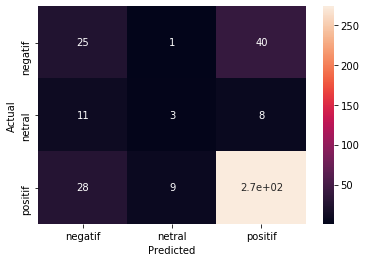

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])